# Genre prediction of songs using KNN algorithms
Modern streaming software in the likes of spotify and Apple music contain an abundance of tracks accounting for more than 220 years worth of listening. This amount is too large for any amount of workforce to classify into genres. Thus there exists a real world need of an algorith which is capable of classifying various songs into appropriate genres and presenting them to curious listeners. Classification through various languages, cultures, and eras is a complicated manner however as it is near impossible to find distinguishing futures for all the possible categories. 
In the following project, we will apply a K-nearest-neighbor algorithm on a dataset containing songs from the four genres R&B, Pop, Rock and Rap and see if the model applies adequately given its predictors. 
The predictors that we shall use are:
- Liveness: Detects presence of audience in the recording and acts as a confidence measure for wether the song was performed live or not.
- Daceability: Considers tempo, rythm, stability, beat strength and overall regularity to measure how suitable a track is for dancing.
- Valence: Measure of musical positiveness.
- Acousticness: Confidence measure of wether a track is acoustic or not.
- Speechiness: The ratio of speech presence in a track.
- Loudness: The overall loudness of a track in decibels scaled to be between 0 and 1 from -60 to 0 db.

# Exploratory Data Analysis
For an exploratory of our dataset before application of an algorithm we shall look at the distribution of the predictors within each genre to see if a noticable difference exists that can be leveraged.
The dataset used was extracted from Kaggle at: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

In [44]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(stringr)
library(rsample)
library(parsnip)
library(recipes)

In [14]:
# Get training data and tracks with relevant genres of pop, rap, rock and r&b.
spotify_tracks <- read_csv("data/spotify_songs.csv") |> 
    filter(playlist_genre != "latin" , playlist_genre != "edm") |> 
    mutate(genre=as_factor(playlist_genre))

# Select predictors and round to specific values.
spotify_char <- spotify_tracks |> 
    select("genre","danceability","liveness","valence","acousticness","speechiness","loudness", "tempo") |> 
    mutate_at(vars(-genre), funs(round(., 2)))

# Prevent future overplotting and overfitting by choosing less data.
set.seed(2024)
spotify_sampled <- sample_n(spotify_char,1300)



Rows: 32833 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): track_id, track_name, track_artist, track_album_id, track_album_na...
dbl (13): track_popularity, danceability, energy, key, loudness, mode, speec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


Here are the charecteristics of songs within our dataframe: 

In [12]:
colnames(spotify_sampled)

[1] "genre"        "danceability" "liveness"     "valence"      "acousticness"
[6] "speechiness"  "loudness"     "tempo"

Just to make sure the distribution of the sampled genres is fairly even, we should plot it.

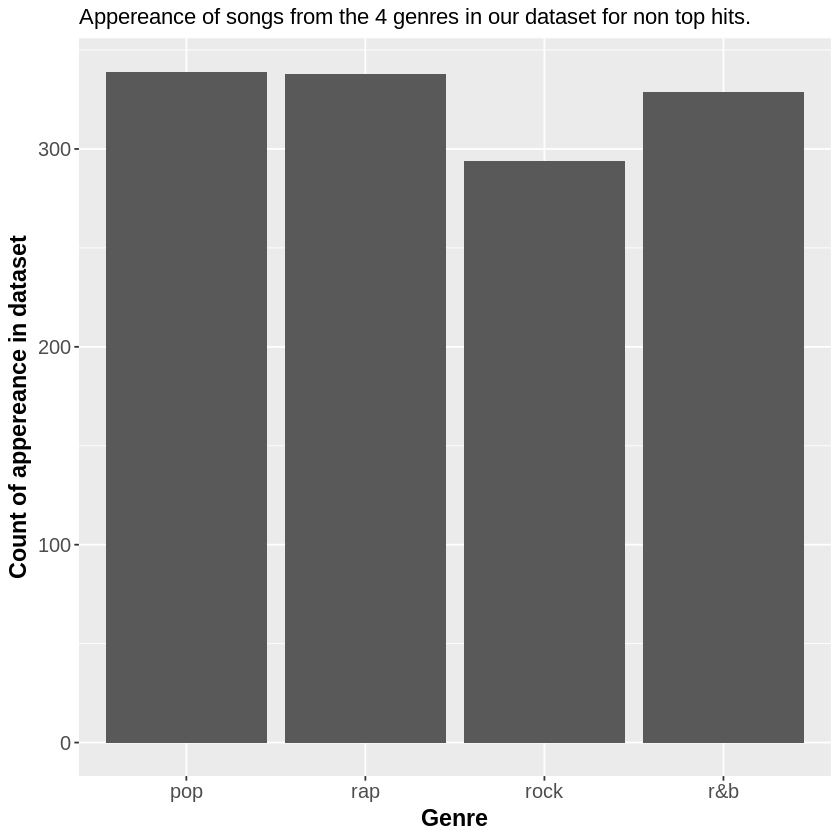

In [10]:
genre_plot <- ggplot(spotify_sampled,aes(x=genre)) + 
    geom_bar(stat="count") + 
    xlab("Genre") + 
    ylab("Count of appereance in dataset") + 
    ggtitle("Appereance of songs from the 4 genres in our dataset for non top hits.") + 
    theme(axis.text=element_text(size=12),
          axis.title=element_text(size=14,face="bold"))

genre_plot
    

As the distribution of genres is satisfactory as a whole, we can be relatively curtain that the KNN algorithm will not be biased towards a specific genre. We may now look to see which of the song charecteristics serve as a good predict for genre.

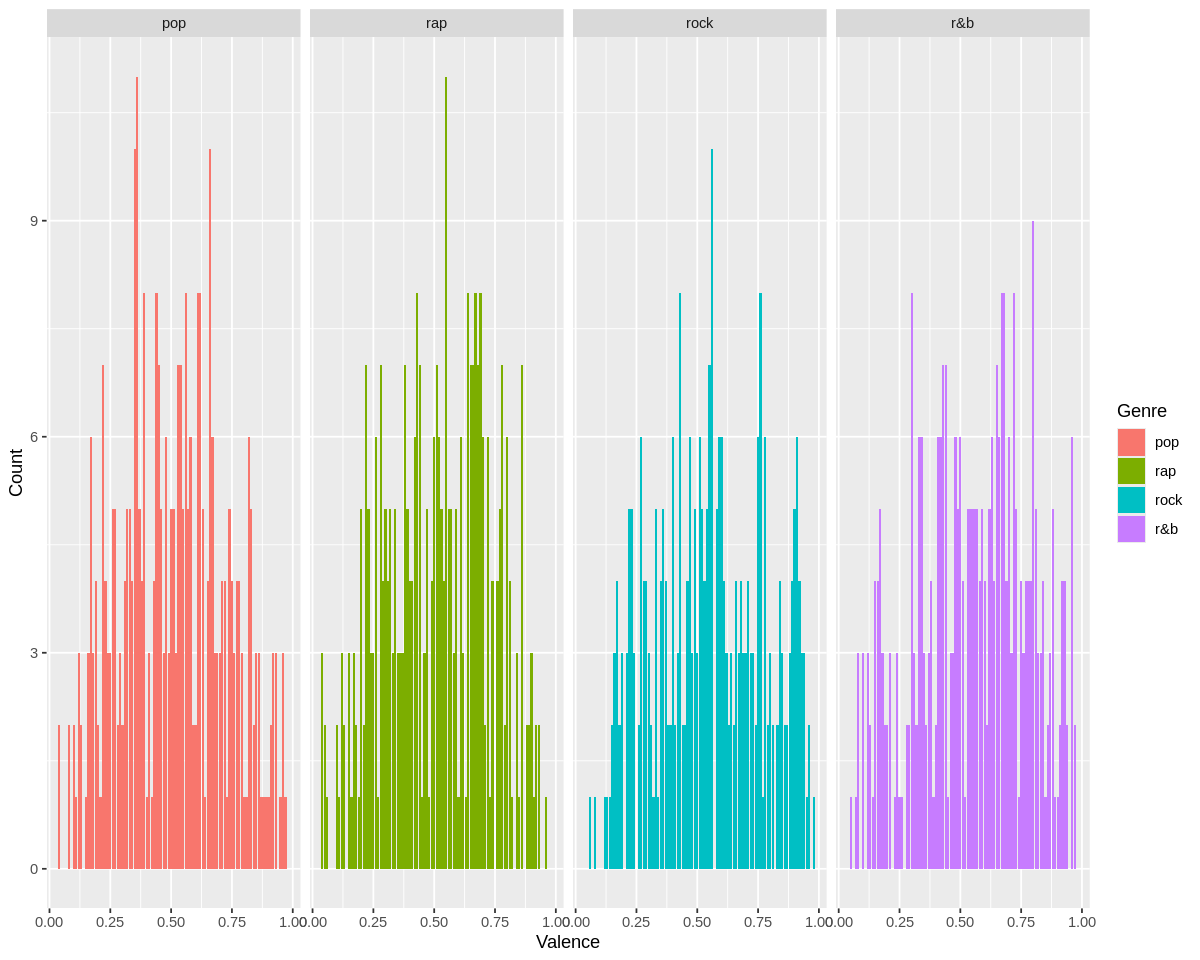

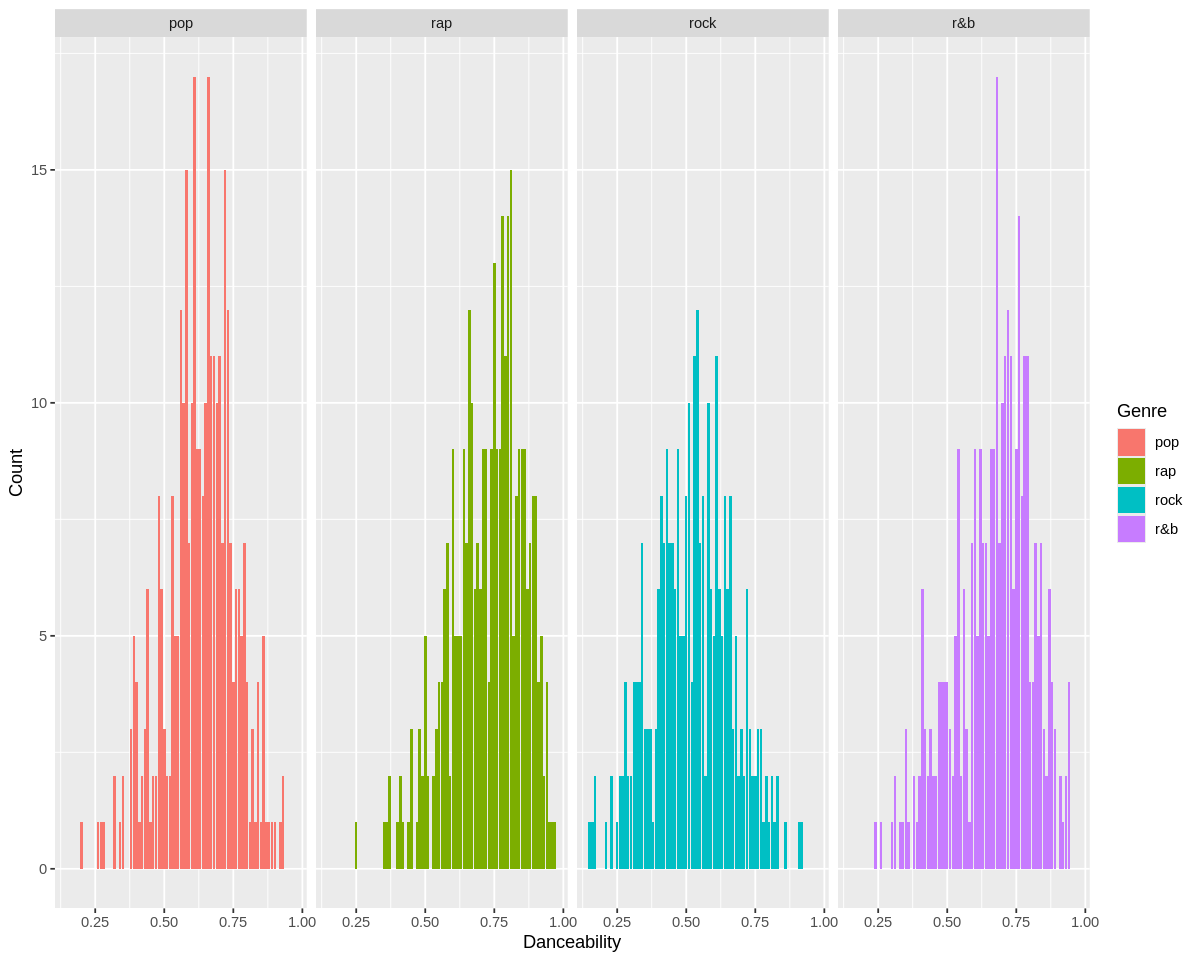

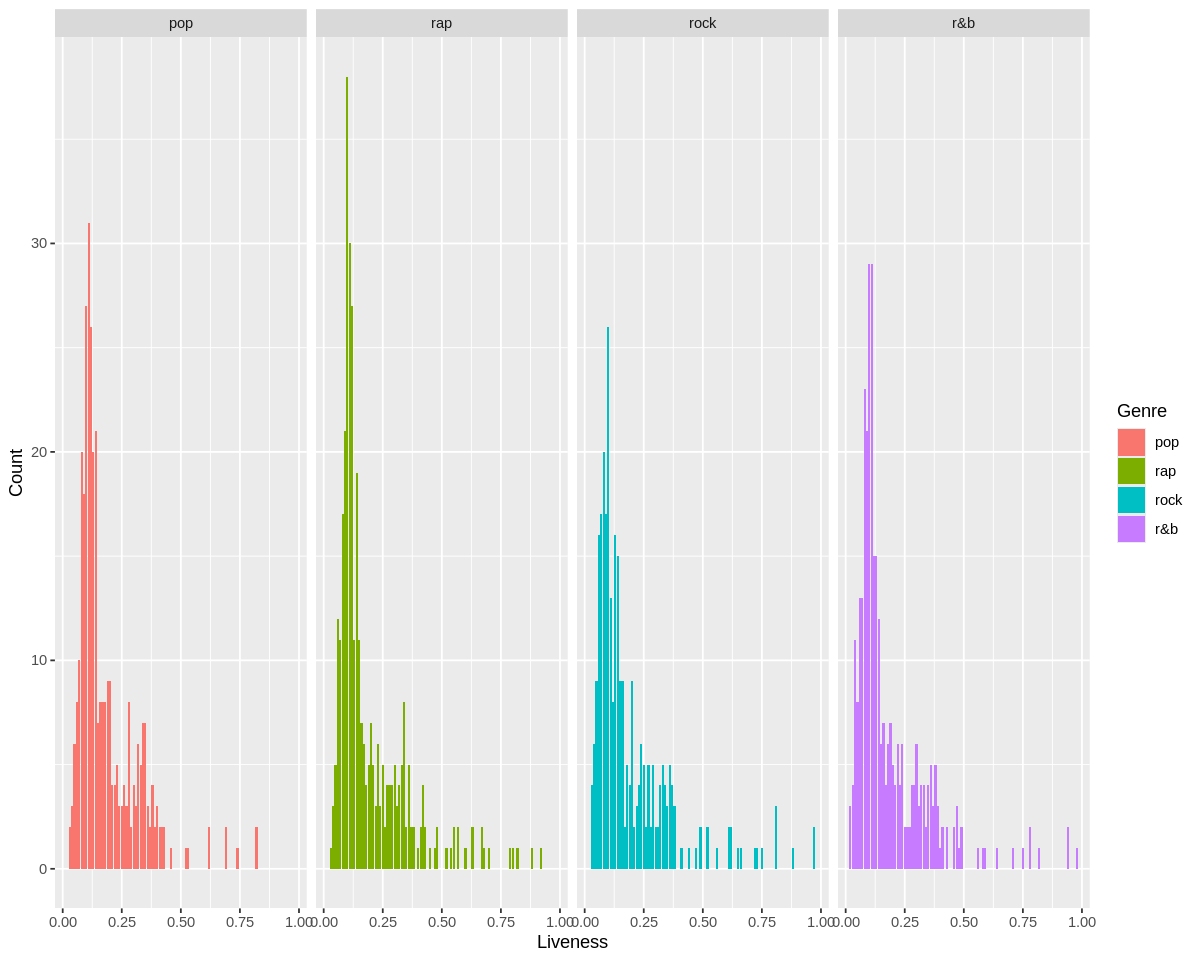

Warning message:
“Removed 226 rows containing non-finite outside the scale range
(`stat_count()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


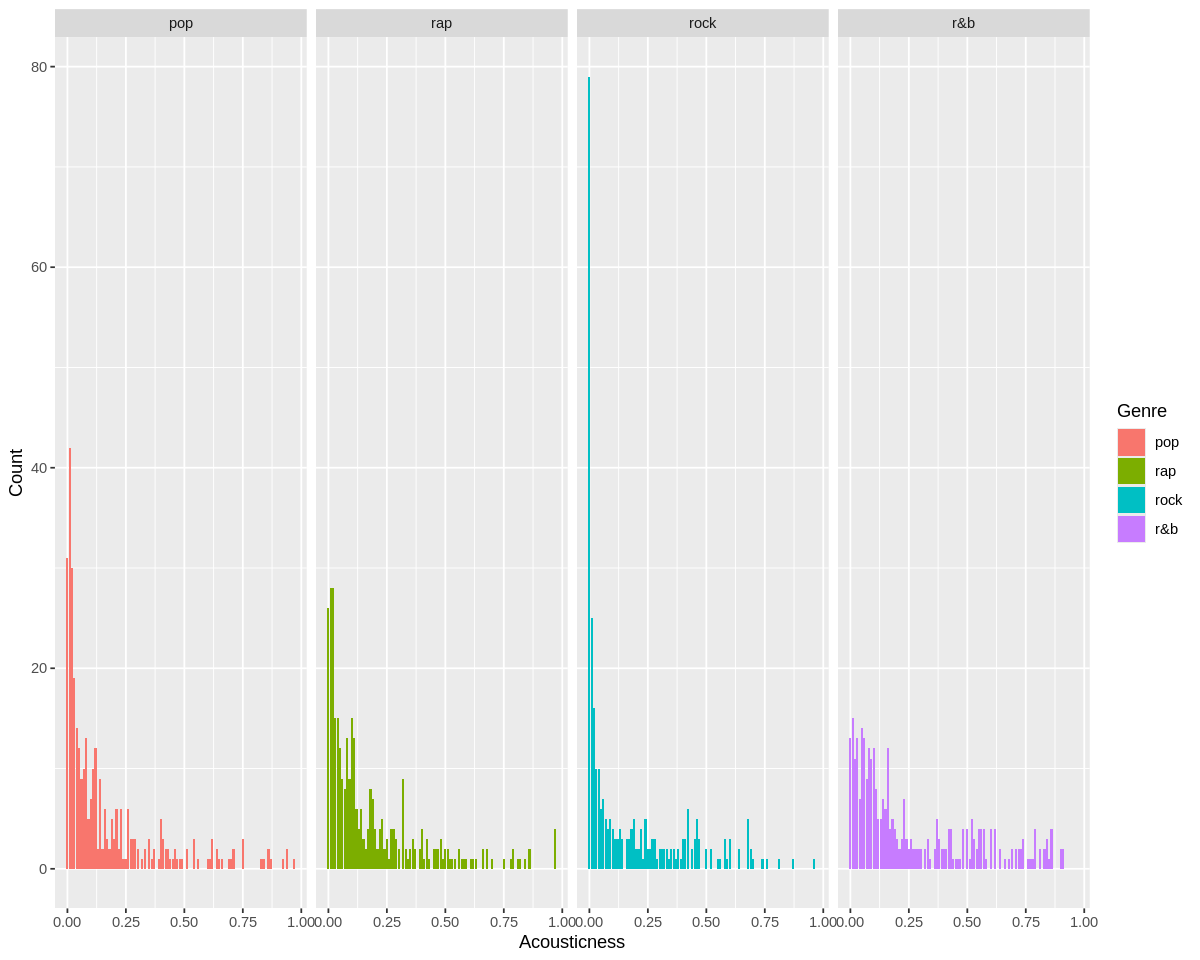

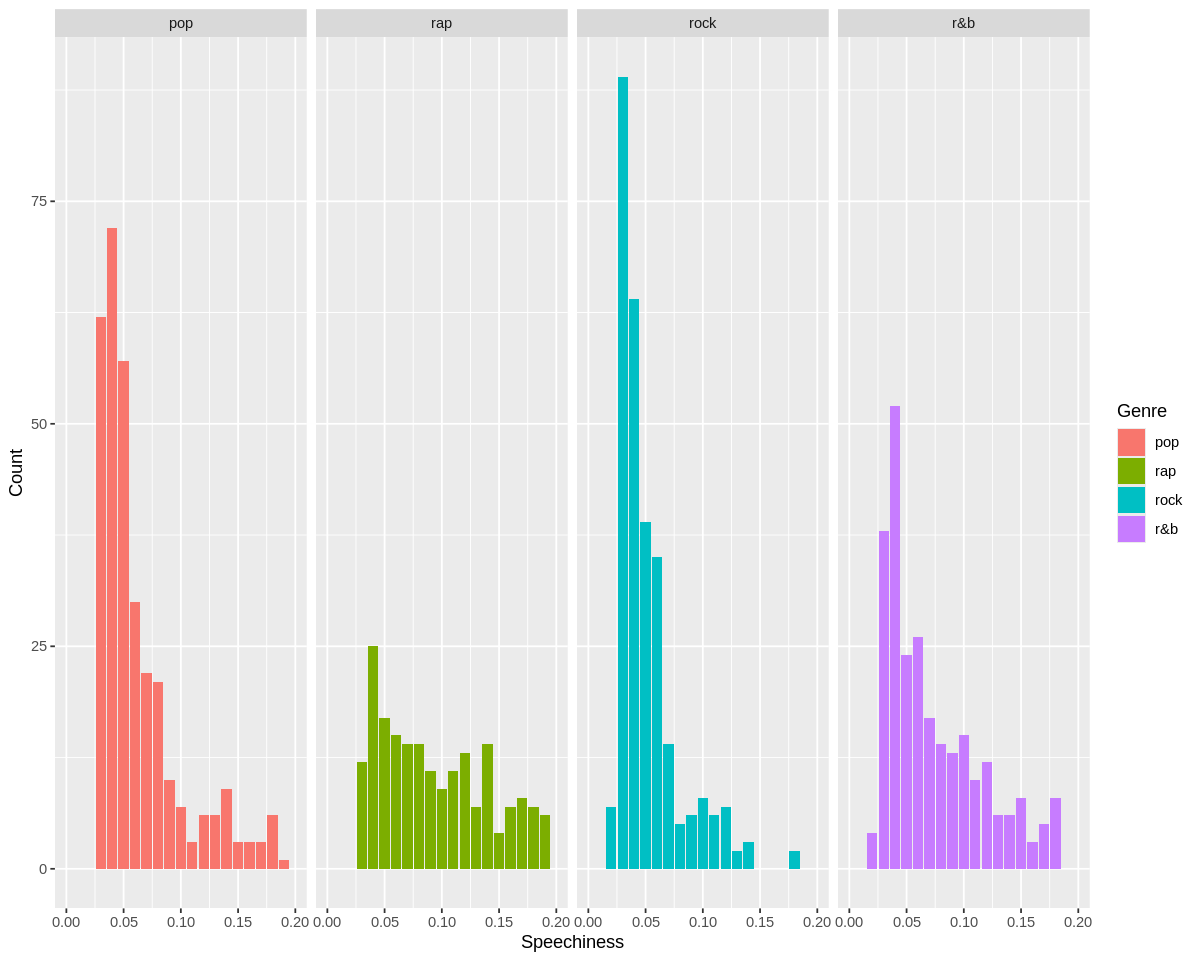

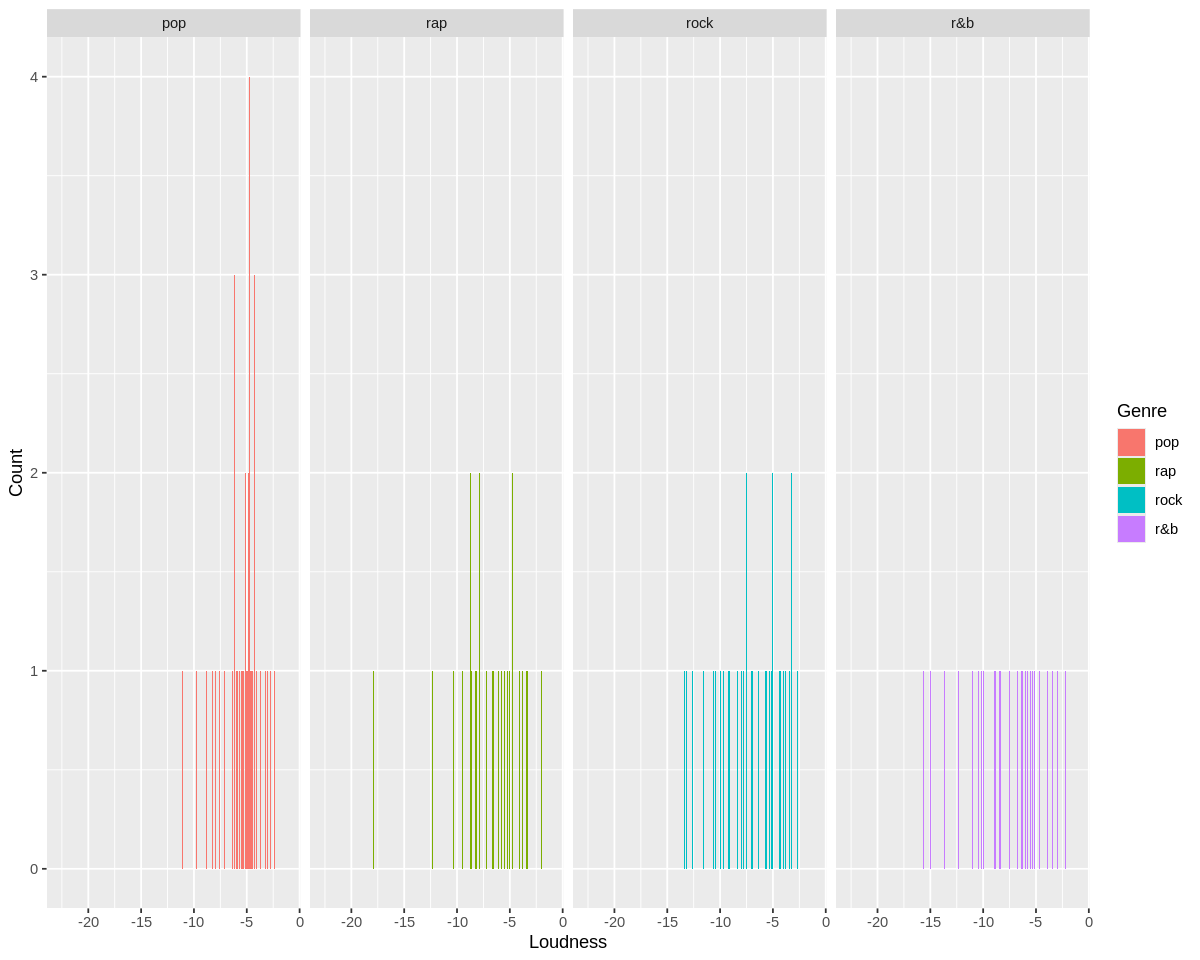

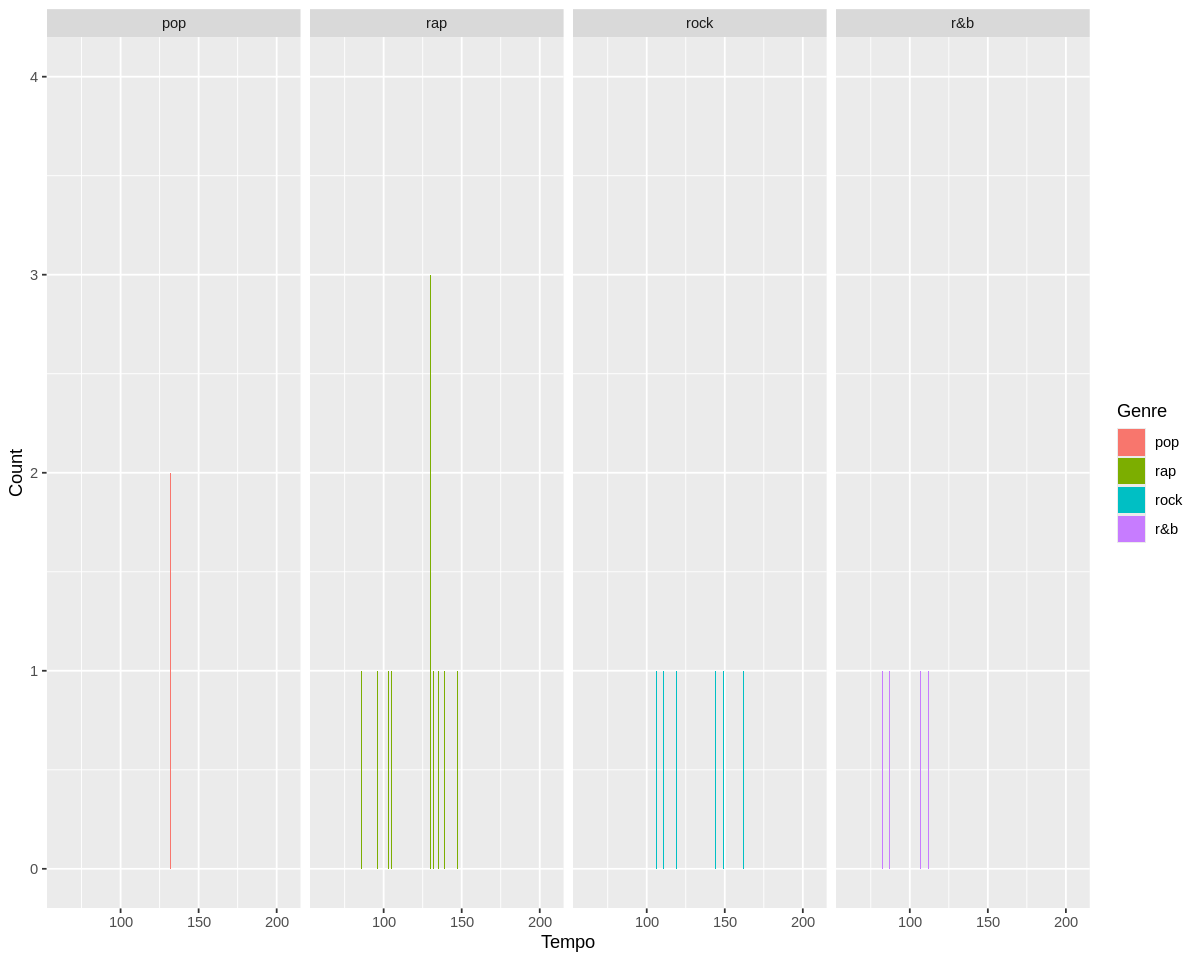

In [11]:
options(repr.plot.width = 10, repr.plot.height =8) 


valence_distributions <- ggplot(spotify_sampled,aes(x=valence,fill=genre)) +
    geom_bar(stat="count",alpha=1,position="dodge") +
    facet_grid(cols=vars(genre)) + 
    xlab("Valence") + 
    ylab("Count") + 
    labs(fill="Genre")

dance_distribution <- ggplot(spotify_sampled,aes(x=danceability,fill=genre)) +
    geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Danceability") + 
    ylab("Count") + 
    labs(fill="Genre")
live_distribution <- ggplot(spotify_sampled,aes(x=liveness,fill=genre)) + 
        geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Liveness") + 
    ylab("Count") + 
    labs(fill="Genre")
acoust_distribution <- ggplot(spotify_sampled,aes(x=acousticness,fill=genre)) + 
        geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Acousticness") + 
    ylab("Count") + 
    labs(fill="Genre")

speech_distribution <- ggplot(spotify_sampled,aes(x=speechiness,fill=genre)) + 
        geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Speechiness") + 
    ylab("Count") + 
    labs(fill="Genre") + 
    scale_x_continuous(limits=c(0,0.2))

loud_distribution <-  ggplot(spotify_sampled,aes(x=loudness,fill=genre)) + 
        geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Loudness") + 
    ylab("Count") + 
    labs(fill="Genre")

tempo_distribution <-  ggplot(spotify_sampled,aes(x=tempo,fill=genre)) + 
        geom_bar(stat="count",alpha=1) +
    facet_grid(cols=vars(genre))  + 
    xlab("Tempo") + 
    ylab("Count") + 
    labs(fill="Genre")


valence_distributions
dance_distribution
live_distribution
acoust_distribution
speech_distribution
loud_distribution
tempo_distribution

Here is the mean of our sampled bit's predictors and the whole dataset, respectively.

In [17]:
sampled_tracks_means <- spotify_sampled |>
    summarise(tempo_mean = mean(tempo),
              danceability_mean = mean(danceability),
              liveness_mean = mean(liveness),
              valence_mean = mean(valence),
              acousticness_mean = mean(acousticness),
              speechiness_mean = mean(acousticness),
              loudness_mean = mean(loudness))
spotify_tracks_means <- spotify_tracks |>
    summarise(tempo_mean = mean(tempo),
              danceability_mean = mean(danceability),
              liveness_mean = mean(liveness),
              valence_mean = mean(valence),
              acousticness_mean = mean(acousticness),
              speechiness_mean = mean(acousticness),
              loudness_mean = mean(loudness))
sampled_tracks_means
spotify_tracks_means
# spotify_tracks_popular <- spotify_tracks |>
# arrange(-track_popularity)

# spotify_tracks_popular

tempo_mean,danceability_mean,liveness_mean,valence_mean,acousticness_mean,speechiness_mean,loudness_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
119.4089,0.6400462,0.1881846,0.5290923,0.1947385,0.1947385,-7.175438


tempo_mean,danceability_mean,liveness_mean,valence_mean,acousticness_mean,speechiness_mean,loudness_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120.0543,0.640872,0.1863955,0.5186356,0.1930627,0.1930627,-7.188814


# Choosing predictors and setting up the algorithm
Looking at these bar plots, tempo, valence, acousticness and liveness of the songs seem to be vacuous in the infromation they yield about genre. Thus our chosen predictors for k-nearest neighbor classifcation currently will ignore these 4 and be loudness ,speechiness ,valence and danceability. 
For training the model, the dataset wrangled above can be used as it contains accurate infromation and does not contain null cells. We shall first determine the number of neighbors to use with folding and then train our model with the concluded number of neighbors. Unfortunately the difference of the predicotrs across genres does not seem to be as large as we hoped. Our model will definitely not be as accurate as orignially predicted.

We first split data into testing and training and set the specifications for out algorithm.

In [19]:
sampled_split <- initial_split(spotify_sampled,prop=0.75,strata=genre)

sampled_training <- training(sampled_split)
sampled_testing <- testing(sampled_split)

knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

knn_rec <- recipe(genre ~ speechiness + acousticness + danceability + valence + loudness, data=sampled_training)

Now we use vfolding to see which number of neighbors from 1 to 20 results in the highest acuracy.

In [21]:
vfold <- vfold_cv(sampled_training,v=5,strata=genre)

gridvals <- tibble(neighbors=seq(1,20))

vfolded_accuracy <- workflow() |> 
    add_recipe(knn_rec) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples=vfold,grid=gridvals) |> 
    collect_metrics() |> 
    filter(.metric=="accuracy")
    

Now we plot the derived accuracies with respect to number of neighbors used to figure out which to use in our cirumstance:

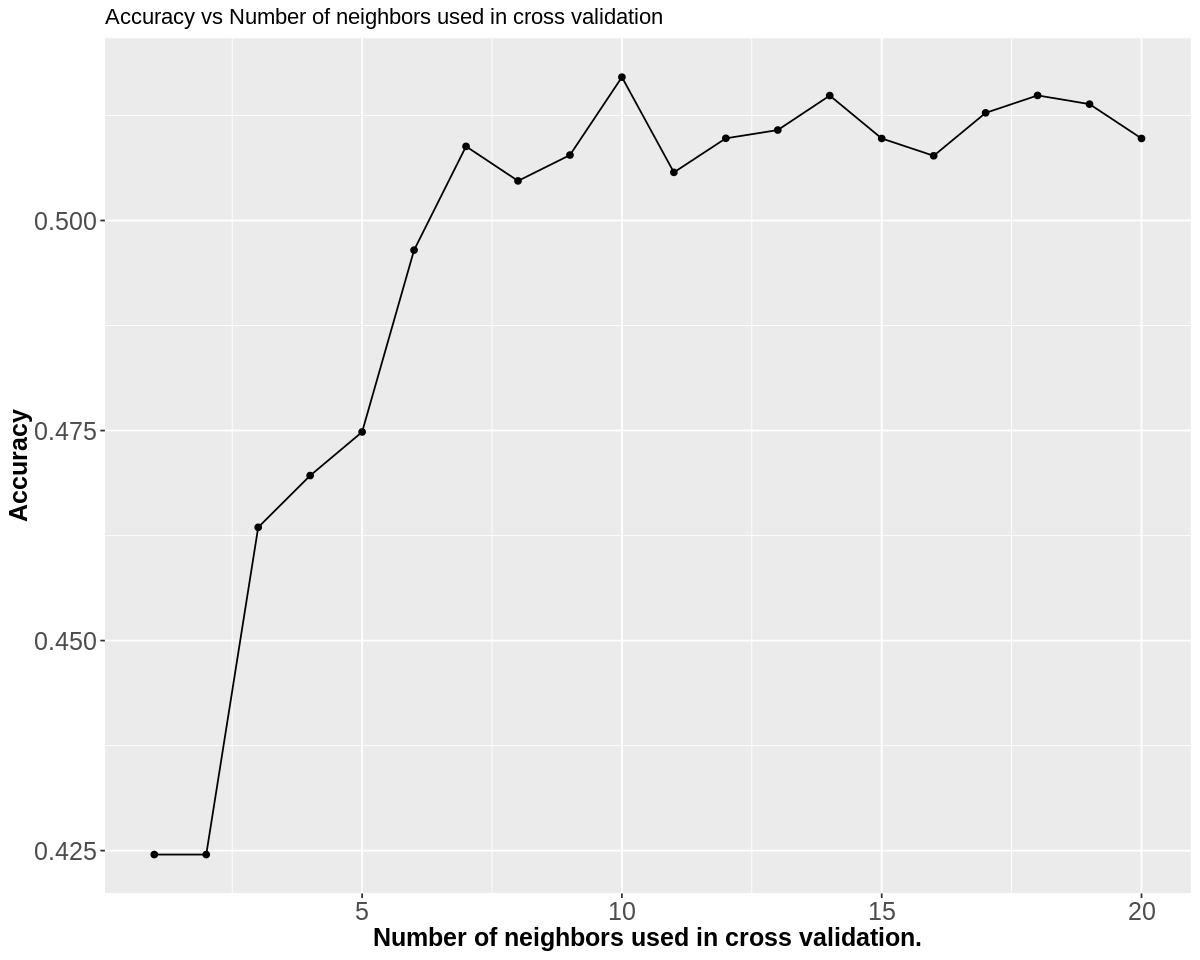

In [31]:
accuracy_plot <- ggplot(vfolded_accuracy,aes(x=neighbors,y=mean)) + 
    geom_point() + 
    geom_line() + 
    xlab("Number of neighbors used in cross validation.") + 
    ylab("Accuracy") +
    ggtitle("Accuracy vs Number of neighbors used in cross validation") +
    xlim(1,20) + 
    theme(axis.text = element_text(size=15),
         axis.title=element_text(size=15,face="bold"))

accuracy_plot
    

Lets try a larger interval of possible neighbors as there seems to be quit the fluctuation.

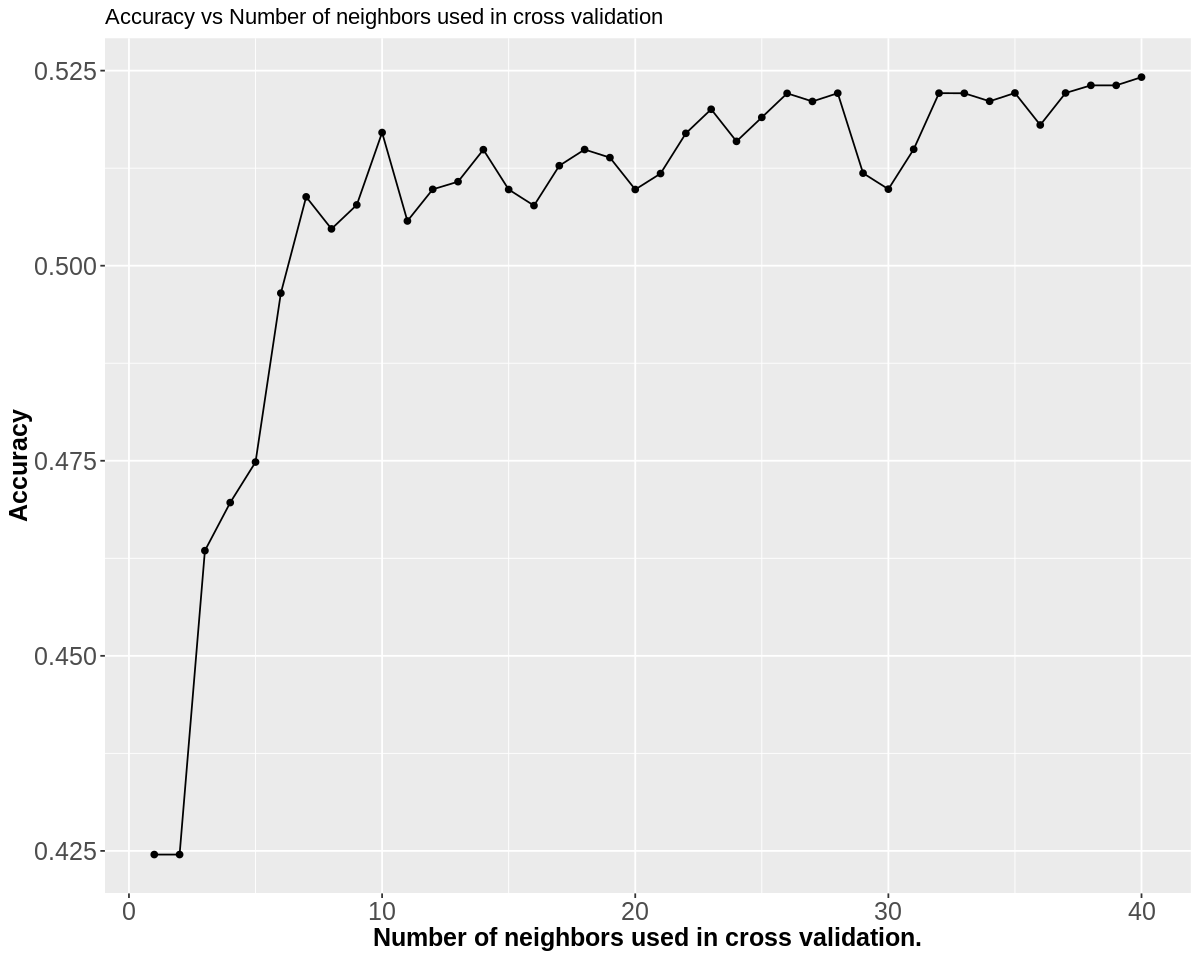

In [29]:
gridvals <- tibble(neighbors=seq(1,40))

new_vfolded_accuracy <- workflow() |>
    add_recipe(knn_rec) |>
    add_model(knn_spec) |> 
    tune_grid(resamples=vfold,grid=gridvals) |> 
    collect_metrics() |> 
    filter(.metric=="accuracy")

accuracy_plot <- ggplot(new_vfolded_accuracy,aes(x=neighbors,y=mean)) + 
    geom_point() + 
    geom_line() + 
    xlab("Number of neighbors used in cross validation.") + 
    ylab("Accuracy") +
    ggtitle("Accuracy vs Number of neighbors used in cross validation") +
    theme(axis.text = element_text(size=15),
         axis.title=element_text(size=15,face="bold"))

accuracy_plot
    

As can be seen in plot(add plot numbers later) the fluctuation persists. Thus we'll choose k=10 to prevent the overfitting lead to by larger k's and reduce time. 

# Training the model and Tesing on test set
Given our chosen k=10, we shall train our model by just chaning one specification.

In [34]:

training_knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=10) |> 
    set_engine("kknn") |> 
    set_mode("classification")

trained_model <- workflow() |> 
    add_recipe(knn_rec) |> 
    add_model(training_knn_spec) |> 
    fit(spotify_sampled)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4976923
Best kernel: rectangular
Best k: 10

Let us now test this model on the testing set to see how it holds up.

In [43]:

predictions <- trained_model |> 
    predict(sampled_testing) |> 
    bind_cols(sampled_testing)  |> 
    metrics(truth=genre,esimate=.pred_class)

predictions

ERROR: [1m[33mError[39m in `metrics()`:[22m
[1m[22m[33m![39m `var` is absent but must be supplied.
